In [446]:
import pandas as pd
import numpy as np
from scipy import stats
from utils import generate_data
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
plt.rcParams["figure.figsize"] = (12,6)

In [2]:
np.random.seed(1)
data = generate_data()

In [3]:
data.x_df.head()
# days since start is z normalized

,intercept,days_since_start,days_since_start_squared,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,seasonality_cos,seasonality_sin
0,1.0,-1.729679,2.228932,0,0,0,0,0,1,0.999852,0.017213
1,1.0,-1.726517,2.216707,0,0,0,0,0,0,0.999407,0.034422
2,1.0,-1.723355,2.204505,1,0,0,0,0,0,0.998667,0.051620
3,1.0,-1.720193,2.192325,0,1,0,0,0,0,0.997630,0.068802
4,1.0,-1.717031,2.180168,0,0,1,0,0,0,0.996298,0.085965


In [25]:
gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)

In [26]:
gpois_res = gpois_mdl.fit()

Optimization terminated successfully.
         Current function value: 6.042689
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23


In [27]:
print(gpois_res.summary2())

                       Results: GeneralizedPoisson
Model:                 GeneralizedPoisson  Pseudo R-squared:  0.046      
Dependent Variable:    y                   AIC:               13257.4897 
Date:                  2022-03-31 14:57    BIC:               13317.4718 
No. Observations:      1095                Log-Likelihood:    -6616.7    
Df Model:              10                  LL-Null:           -6938.4    
Df Residuals:          1084                LLR p-value:       9.1750e-132
Converged:             1.0000              Scale:             1.0000     
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
intercept                 5.2691   0.0390 135.0435 0.0000  5.1927  5.3456
days_since_start          0.3443   0.0149  23.0411 0.0000  0.3150  0.3736
days_since_start_squared -0.1218   0.0140  -8.7024 0.0000 -0.

In [456]:
# Marginal effects
me = gpois_res.get_margeff(method='dydx')
me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
 GeneralizedPoisson Marginal Effects 
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
============================================================================================
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
days_since_start            84.4801      3.907     21.625      0.000      76.823      92.137
days_since_start_squared   -29.8891      3.468     -8.620      0.000     -36.685     -23.093
day_of_week_1               48.3888     12.614      3.836      0.000      23.665      73.112
day_of_week_2               45.7302     12.694      3.603      0.000      20.851      70.609
day_of_week_3               67.2364     12.534      5.364      0.000      42.670      91.803
day_of_week_4               70.9190     12.528      5.661      0.000      46.364      95.474
day_of_week_5               40.8195     12.678      3.220      0.001      15.971      65.668
day_of_week_6                5.5204     12.938      0.427      0.670     -19.838      30.879
seasonality_cos             29.3383      4.694      6.250      0.000      20.138      38.538
seasonality_sin            -12.9319      4.884     -2.648      0.008     -22.504      -3.360
============================================================================================
"""

## Extend Generic Likelihood Model

In [173]:
def _ll_latentnorm(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))
    Phi_bar = stats.norm(mu, sigma).cdf(np.log1p(y))
    Phi_underbar = stats.norm(mu, sigma).cdf(np.log(y))
    ll = np.log(Phi_bar - Phi_underbar)
    #print(Phi_bar.sum())
    #print(Phi_underbar.sum())
    #print(ll.sum())
    return ll

def _gradutils(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))

    z_bar = (np.log1p(y) - mu) / sigma 
    z_underbar = (np.log(y) - mu) / sigma

    Phi_bar = stats.norm.cdf(z_bar)
    Phi_underbar = stats.norm.cdf(z_underbar)
    Phi  = Phi_bar - Phi_underbar

    phi_bar = stats.norm.pdf(z_bar)
    phi_underbar = stats.norm.pdf(z_underbar)
    phi = phi_bar - phi_underbar
    
    kappa_0 = phi / Phi
    kappa_1 = (z_bar * phi_bar - z_underbar * phi_underbar) / Phi
    kappa_2 = (z_bar**2 * phi_bar - z_underbar**2 * phi_underbar) / Phi
    kappa_3 = (z_bar**3 * phi_bar - z_underbar**3 * phi_underbar) / Phi
    
    return kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma
    
def _vec_matrix_multiply(a, B):
    return np.apply_along_axis(lambda x: x * a, 0, B)

In [474]:
class MyLatentNormal(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyLatentNormal, self).__init__(endog, exog, **kwds)
        self.nparams = 22
        
    def nloglikeobs(self, params):
        exog = self.exog
        endog = self.endog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        ll = _ll_latentnorm(endog, exog, beta, alph)
        params_alt = params.copy()
        params_alt[0] = 0.
#         params_alt[11] = 0.
        return -ll - self.penalty*np.sum(params_alt**2)/self.endog.size
    
    def score(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        beta_alt = beta.copy()
        beta_alt[0] = 0
        alph_alt = alph.copy()
#         alph_alt[0] = 0.
        
        grad_beta = -(kappa_0 / sigma) @ X - penalty*2 * beta_alt
        grad_alph = -kappa_1 @ X - self.penalty*2 * alph_alt
        
        return np.append(grad_beta, grad_alph)
    
    def hessian(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        #xx = np.einsum('ij,ij-> i', X, X) # row-wise dot product?
        k_beta = (kappa_0**2 + kappa_1) / sigma**2
        k_alph = kappa_1 * (kappa_1 - 1) + kappa_3
        k_beta_alph = (kappa_2 + kappa_0*(kappa_1 - 1)) / sigma
        H_beta = np.zeros([11, 11])
        H_alph = np.zeros([11, 11])
        H_beta_alph = np.zeros([11, 11])
                  
        for i in range(X.shape[0]):
            x = X[i]
            xxT = np.outer(x, x)
            H_beta -= k_beta[i] * xxT
            H_alph -= k_alph[i] * xxT
            H_beta_alph -= k_beta_alph[i] * xxT
        
        H_all = np.block([[H_beta, H_beta_alph], [H_beta_alph.T, H_alph]]) # 22 x 22
        penalty_matrix = self.penalty*2 * np.eye(22)
        penalty_matrix[0, 0] = 0.
#         penalty_matrix[11, 11] = 0.

        return H_all - penalty_matrix
    
    def predict(self, params, exog=None, n=1000):
        if exog is None:
            X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        mu = (np.dot(X, beta))
        sigma = np.exp(np.dot(X, alph))
        Z = stats.norm(mu,sigma).rvs(size = (n, self.endog.size))
        Y_hat = np.floor(np.exp(Z)).mean(axis=0)
        return Y_hat
    
    def mse(self):
        print("test")
        
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, penalty=1., **kwds):
        self.penalty = penalty
        #print(self.penalty)
        if start_params is None:
            # Reasonable starting values
            start_params = np.zeros(self.nparams)
            start_params[0] = np.log(np.mean(self.endog)) # beta
        return super(MyLatentNormal, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

In [475]:
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]

In [476]:
mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)

In [478]:
#start_params =  0. * np.ones(22)
#start_params[:11] = gpois_res.params[:11] # Warm start with estimates of betas
#start_params[11] = -1. # It's really sensitive to this starting value
mod_res = mod.fit(method="ncg", maxiter=100, start_params = None, penalty= 1) 

Optimization terminated successfully.
         Current function value: 5.927334
         Iterations: 10
         Function evaluations: 19
         Gradient evaluations: 17
         Hessian evaluations: 10


<ipython-input-173-8b762fec5c2c>:6: RuntimeWarning: divide by zero encountered in log
  ll = np.log(Phi_bar - Phi_underbar)
<ipython-input-173-8b762fec5c2c>:27: RuntimeWarning: divide by zero encountered in true_divide
  kappa_0 = phi / Phi
<ipython-input-173-8b762fec5c2c>:27: RuntimeWarning: invalid value encountered in true_divide
  kappa_0 = phi / Phi
<ipython-input-173-8b762fec5c2c>:28: RuntimeWarning: divide by zero encountered in true_divide
  kappa_1 = (z_bar * phi_bar - z_underbar * phi_underbar) / Phi
<ipython-input-173-8b762fec5c2c>:28: RuntimeWarning: invalid value encountered in true_divide
  kappa_1 = (z_bar * phi_bar - z_underbar * phi_underbar) / Phi
<ipython-input-173-8b762fec5c2c>:29: RuntimeWarning: divide by zero encountered in true_divide
  kappa_2 = (z_bar**2 * phi_bar - z_underbar**2 * phi_underbar) / Phi
<ipython-input-173-8b762fec5c2c>:29: RuntimeWarning: invalid value encountered in true_divide
  kappa_2 = (z_bar**2 * phi_bar - z_underbar**2 * phi_underbar) / P

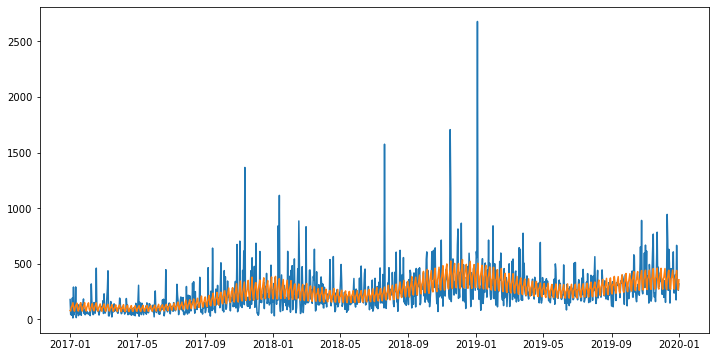

In [479]:
Y_hat = mod_res.predict()
plt.plot(data.days, data.y)
plt.plot(data.days, Y_hat)
plt.show()

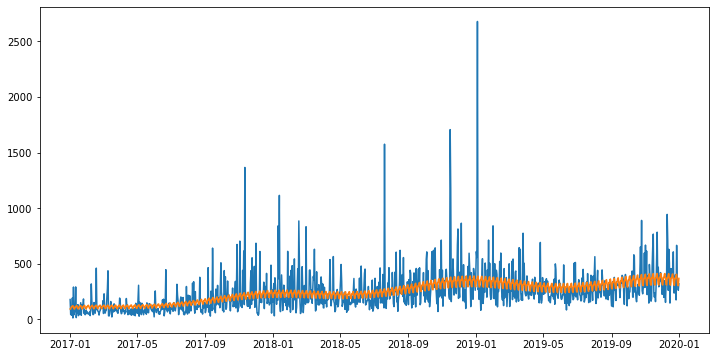

In [480]:
plt.plot(data.days, data.y)
plt.plot(data.days, gpois_res.predict())
plt.show()

In [481]:
print(mod_res.summary())
print(f"True Beta: {data.beta}")
print(f"True Alpha: {data.alpha}")

                            MyLatentNormal Results                            
Dep. Variable:                      y   Log-Likelihood:                -6490.4
Model:                 MyLatentNormal   AIC:                         1.300e+04
Method:            Maximum Likelihood   BIC:                         1.306e+04
Date:                Thu, 31 Mar 2022                                         
Time:                        17:17:54                                         
No. Observations:                1095                                         
Df Residuals:                    1084                                         
Df Model:                          10                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          5.0373      0.027    188.698      0.000       4.985     

In [306]:
# Negative Hessian is PD at optimal values
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, -1., -0.2, -0.03, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.16, -0.05])
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
np.linalg.eigvals(-mod.hessian(starting_vals))

array([1239.40909447, 1169.52333052, 1111.64149088,  864.30006269,
        672.26168113,  533.12565814,  488.33293005,  379.91785823,
        277.77613696,    7.36287204,   21.80117537,  220.94008611,
         57.09792013,   68.82228866,   83.88336387,  104.34541364,
        112.89569071,  153.64095429,  161.01961849,  155.23095091,
        158.95180193,  157.82744299])

In [307]:
mod_res.mle_retvals

{'fopt': 5.92970640834016,
 'fcalls': 168,
 'gcalls': 167,
 'warnflag': 0,
 'converged': True}

In [483]:
bs = mod_res.bootstrap(nrep=10, method="cg", store = 0, disp = 0) # we can bootstrap SE
bs[0] #mean estimates

/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 5.04019304,  0.39188427, -0.15317003,  0.25720121,  0.25636979,
        0.37518375,  0.43729665,  0.24483793,  0.04732622,  0.17755736,
       -0.07140271, -1.09248815, -0.20357987, -0.05530052,  0.28828822,
        0.44055755,  0.52900676,  0.55672947,  0.24306557,  0.12499398,
        0.19445223, -0.08947347])